In [1]:
import torch, numpy as np, pandas as pd
import sklearn as sk
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, Dataset
from scipy.ndimage.measurements import center_of_mass
from sklearn.model_selection import train_test_split

<ipython-input-1-fe302d509ea6>:6: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
!mkdir attempt1

## Data Preparation ##

In [3]:
INPUT_PATH = 'https://cernbox.cern.ch/remote.php/dav/public-files/dbwReGGBIPARvqM/converted_all.csv'
layers = [0]
cell_sizes_cm = [1.515, 3.03, 4.04, 6.06, 12.12]
#cell_sizes_cm = [1.515]

In [4]:
def get_time_cell_3x3(row):
    time = row[:9]
    energy = row[9:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_time_cell_5x5(row):
    time = row[:25]
    energy = row[25:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_features(df):
    df['xGen_pred'] = 0.0
    df['yGen_pred'] = 0.0
    df['p_pred'] = 0.0
    df['t_pred'] = 0.0

    for layer in layers:
        df['l{}_sum_3x3'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in [6,7,8,
                                                    11,12,13,
                                                    16,17,18]]].values.sum(axis=1)

        df['l{}_sum_5x5'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=1)


    df['z_ref'] = np.zeros_like(df['entry_x'].values)
    df.loc[df['cell_size'] == 1.515, 'z_ref'] = 7.0
    df.loc[df['cell_size'] == 3.03, 'z_ref'] = 10.0
    df.loc[df['cell_size'] == 4.04, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 6.06, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 12.12, 'z_ref'] = 0.0
    
    barycenter = np.apply_along_axis(get_center_cluster, axis=1,
                                     arr = df[['cell_size'] + \
                                              ['l{}_{}'.format(0, i) for i in range(25)]].values)       
        
    for i, axis in enumerate(['x','y']):
        df['l0_{}_bar'.format(axis)] = \
            barycenter[:,i] + \
            df['{}_seed_shift'.format(axis)].values * df['cell_size'].values

        df['entry_{}_new'.format(axis)] = \
            (df['entry_{}'.format(axis)].values*0.1 + \
             df['z_ref'].values * (df['p{}'.format(axis)].values / df['pz'].values)) * 10

### angle
        df['l0_{}_bar_cal'.format(axis)] = \
            np.floor(df['entry_{}'.format(axis)].values * 0.1 / df['cell_size'].values) * \
            df['cell_size'].values + 0.5 * df['cell_size'].values + \
            df['l0_{}_bar'.format(axis)]

        df['l0_{}Rec_loc'.format(axis)] = \
            df['l0_{}_bar_cal'.format(axis)].values - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)

        df['l0_{}Gen_loc'.format(axis)] = \
            df['entry_{}_new'.format(axis)].values*0.1 - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)
    
    for layer in layers:
        df['t{}_weighted_3x3'.format(layer)] = np.apply_along_axis(get_time_cell_3x3, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]] + \
                                                           ['l{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]]].values)

        df['t{}_weighted_5x5'.format(layer)] = np.apply_along_axis(get_time_cell_5x5, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in range(25)] + \
                                                           ['l{}_{}'.format(layer,c) for c in range(25)]].values)

In [5]:
def get_center_cluster(row):
    return (np.array(center_of_mass(row[1:].reshape(5,5))) - 2.0) * row[0]


def get_rmse(x, y):
    return np.nanmean(((x - y) ** 2.0)) ** 0.5


def get_rmse_metric(x, y, folds=5):
    if x.shape != y.shape:
        print('x.shape != y.shape')
        raise

    splits = np.array_split(np.arange(len(x)), folds)

    rmse = []
    for split in splits:
        rmse.append(get_rmse(x[split], y[split]))

    return np.nanmean(rmse), np.nanstd(rmse)

In [6]:
def calib(df):
    cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]

    A = dict()
    B = dict()

    A[0] = dict()
    B[0] = dict()
    A[0][1.515] = 0.00497
    B[0][1.515] = 109.5
    A[0][3.03] = 0.09641
    B[0][3.03] = 23.4
    A[0][4.04] = 0.2382
    B[0][4.04] = 70.72
    A[0][6.06] = 0.2401
    B[0][6.06] = 75.22
    A[0][12.12] = 0.2458
    B[0][12.12] = 57.76

    for layer in layers:
        for cell_size in cell_sizes:
            for cell_num in range(25):
                e_calib = df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] * A[layer][cell_size] + \
                        B[layer][cell_size]
                df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] = \
                    np.clip(e_calib, a_min=0, a_max=None)

    return df

In [7]:
nPV_start_time = datetime.now()
data_train = pd.read_csv(INPUT_PATH)#[:N_SIGNALS]

data_train = data_train[~np.isnan(data_train.l0_12.values)].reset_index(drop=True)

data_train = calib(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

data_train['p_ECAL'] = data_train['eKinetic'].values * 1000
data_train['t_ECAL'] = data_train.timing.values

data_train['x_ECAL'] = data_train.entry_x.values
data_train['y_ECAL'] = data_train.entry_y.values
data_train['z_ECAL'] = data_train.entry_z.values

data_train = data_train[data_train['p_ECAL'] < 100000]

In [8]:
for layer in layers:
    data_train['l{}_sum_5x5_rec'.format(layer)] = 0.0

    for cell_size in cell_sizes_cm:
        sum_of_cluster = data_train[data_train.cell_size == cell_size][['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=-1)
        corr_coef = np.nanmean((data_train[data_train.cell_size == cell_size].p_ECAL.values)) / np.nanmean(sum_of_cluster)
        data_train.loc[data_train.cell_size == cell_size, 'l{}_sum_5x5_rec'.format(layer)] = sum_of_cluster * corr_coef

get_features(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

<ipython-input-8-daf3c6346b55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['l{}_sum_5x5_rec'.format(layer)] = 0.0


In [9]:
cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]

(array([[23., 19., 22., ..., 18.,  8., 20.],
        [14., 14., 16., ..., 17., 17., 11.],
        [18., 19.,  9., ..., 10., 11., 17.],
        ...,
        [11., 15., 14., ..., 15., 10., 16.],
        [13., 19., 10., ..., 28.,  6., 21.],
        [25., 29.,  6., ..., 26., 16., 15.]]),
 array([-7.57496362e-01, -7.42346573e-01, -7.27196784e-01, -7.12046995e-01,
        -6.96897206e-01, -6.81747417e-01, -6.66597628e-01, -6.51447839e-01,
        -6.36298050e-01, -6.21148261e-01, -6.05998472e-01, -5.90848682e-01,
        -5.75698893e-01, -5.60549104e-01, -5.45399315e-01, -5.30249526e-01,
        -5.15099737e-01, -4.99949948e-01, -4.84800159e-01, -4.69650370e-01,
        -4.54500581e-01, -4.39350792e-01, -4.24201003e-01, -4.09051214e-01,
        -3.93901425e-01, -3.78751636e-01, -3.63601847e-01, -3.48452058e-01,
        -3.33302268e-01, -3.18152479e-01, -3.03002690e-01, -2.87852901e-01,
        -2.72703112e-01, -2.57553323e-01, -2.42403534e-01, -2.27253745e-01,
        -2.12103956e-01, -1.969

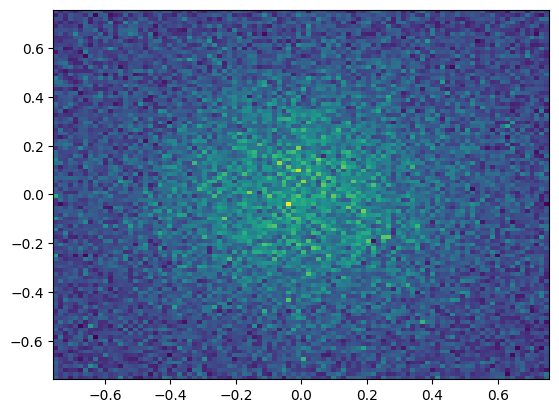

In [10]:
import matplotlib.pyplot as plt

plt.hist2d(data_train[data_train.cell_size == cell_sizes[0]].l0_yRec_loc, data_train[data_train.cell_size == cell_sizes[0]].l0_xRec_loc, bins=100)

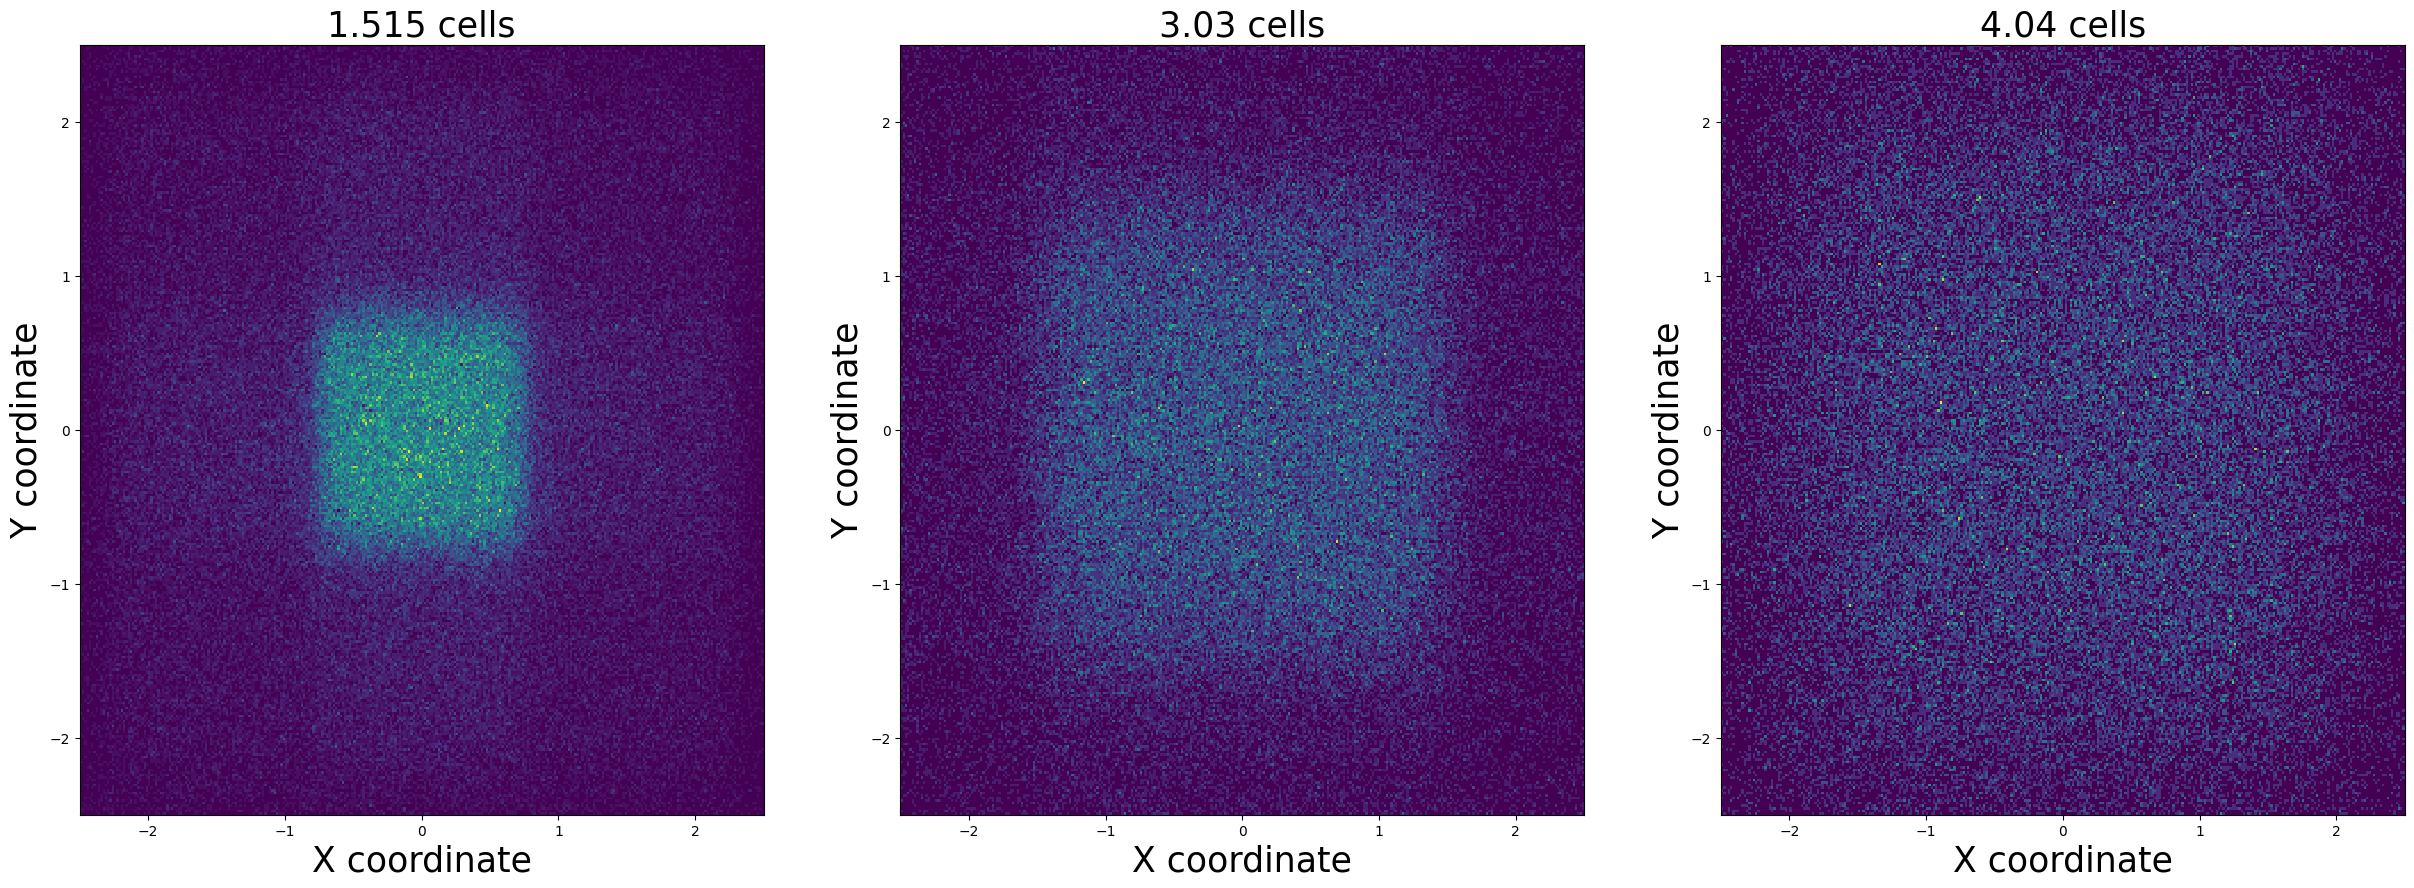

In [11]:
import matplotlib.pyplot as plt
import matplotlib
font_size = 25
fig, axs = plt.subplots(1, 3)

axs[0].hist2d(data_train[data_train.cell_size == cell_sizes[0]].l0_yGen_loc, data_train[data_train.cell_size == cell_sizes[0]].l0_xGen_loc, bins=300, \
                 range = [[-2.5,2.5],[-2.5,2.5]])
axs[0].set_title(str(cell_sizes[0]) + ' cells', fontsize=font_size)
axs[1].hist2d(data_train[data_train.cell_size == cell_sizes[1]].l0_yGen_loc, data_train[data_train.cell_size == cell_sizes[1]].l0_xGen_loc, bins=300, \
                 range = [[-2.5,2.5],[-2.5,2.5]])
axs[1].set_title(str(cell_sizes[1]) + ' cells', fontsize = font_size)
axs[2].hist2d(data_train[data_train.cell_size == cell_sizes[2]].l0_yGen_loc, data_train[data_train.cell_size == cell_sizes[2]].l0_xGen_loc, bins=300, \
                 range = [[-2.5,2.5],[-2.5,2.5]])
axs[2].set_title(str(cell_sizes[2]) + ' cells',fontsize = font_size)
fig.set_figheight(10)
fig.set_figwidth(30)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

for ax in axs.flat:
   ax.set_xlabel('X coordinate', fontsize=font_size)
   ax.set_ylabel('Y coordinate', fontsize=font_size)
   #ax.set(xlabel='X coordinate', ylabel='Y coordinate', fontsize = font_size)

fig.show()


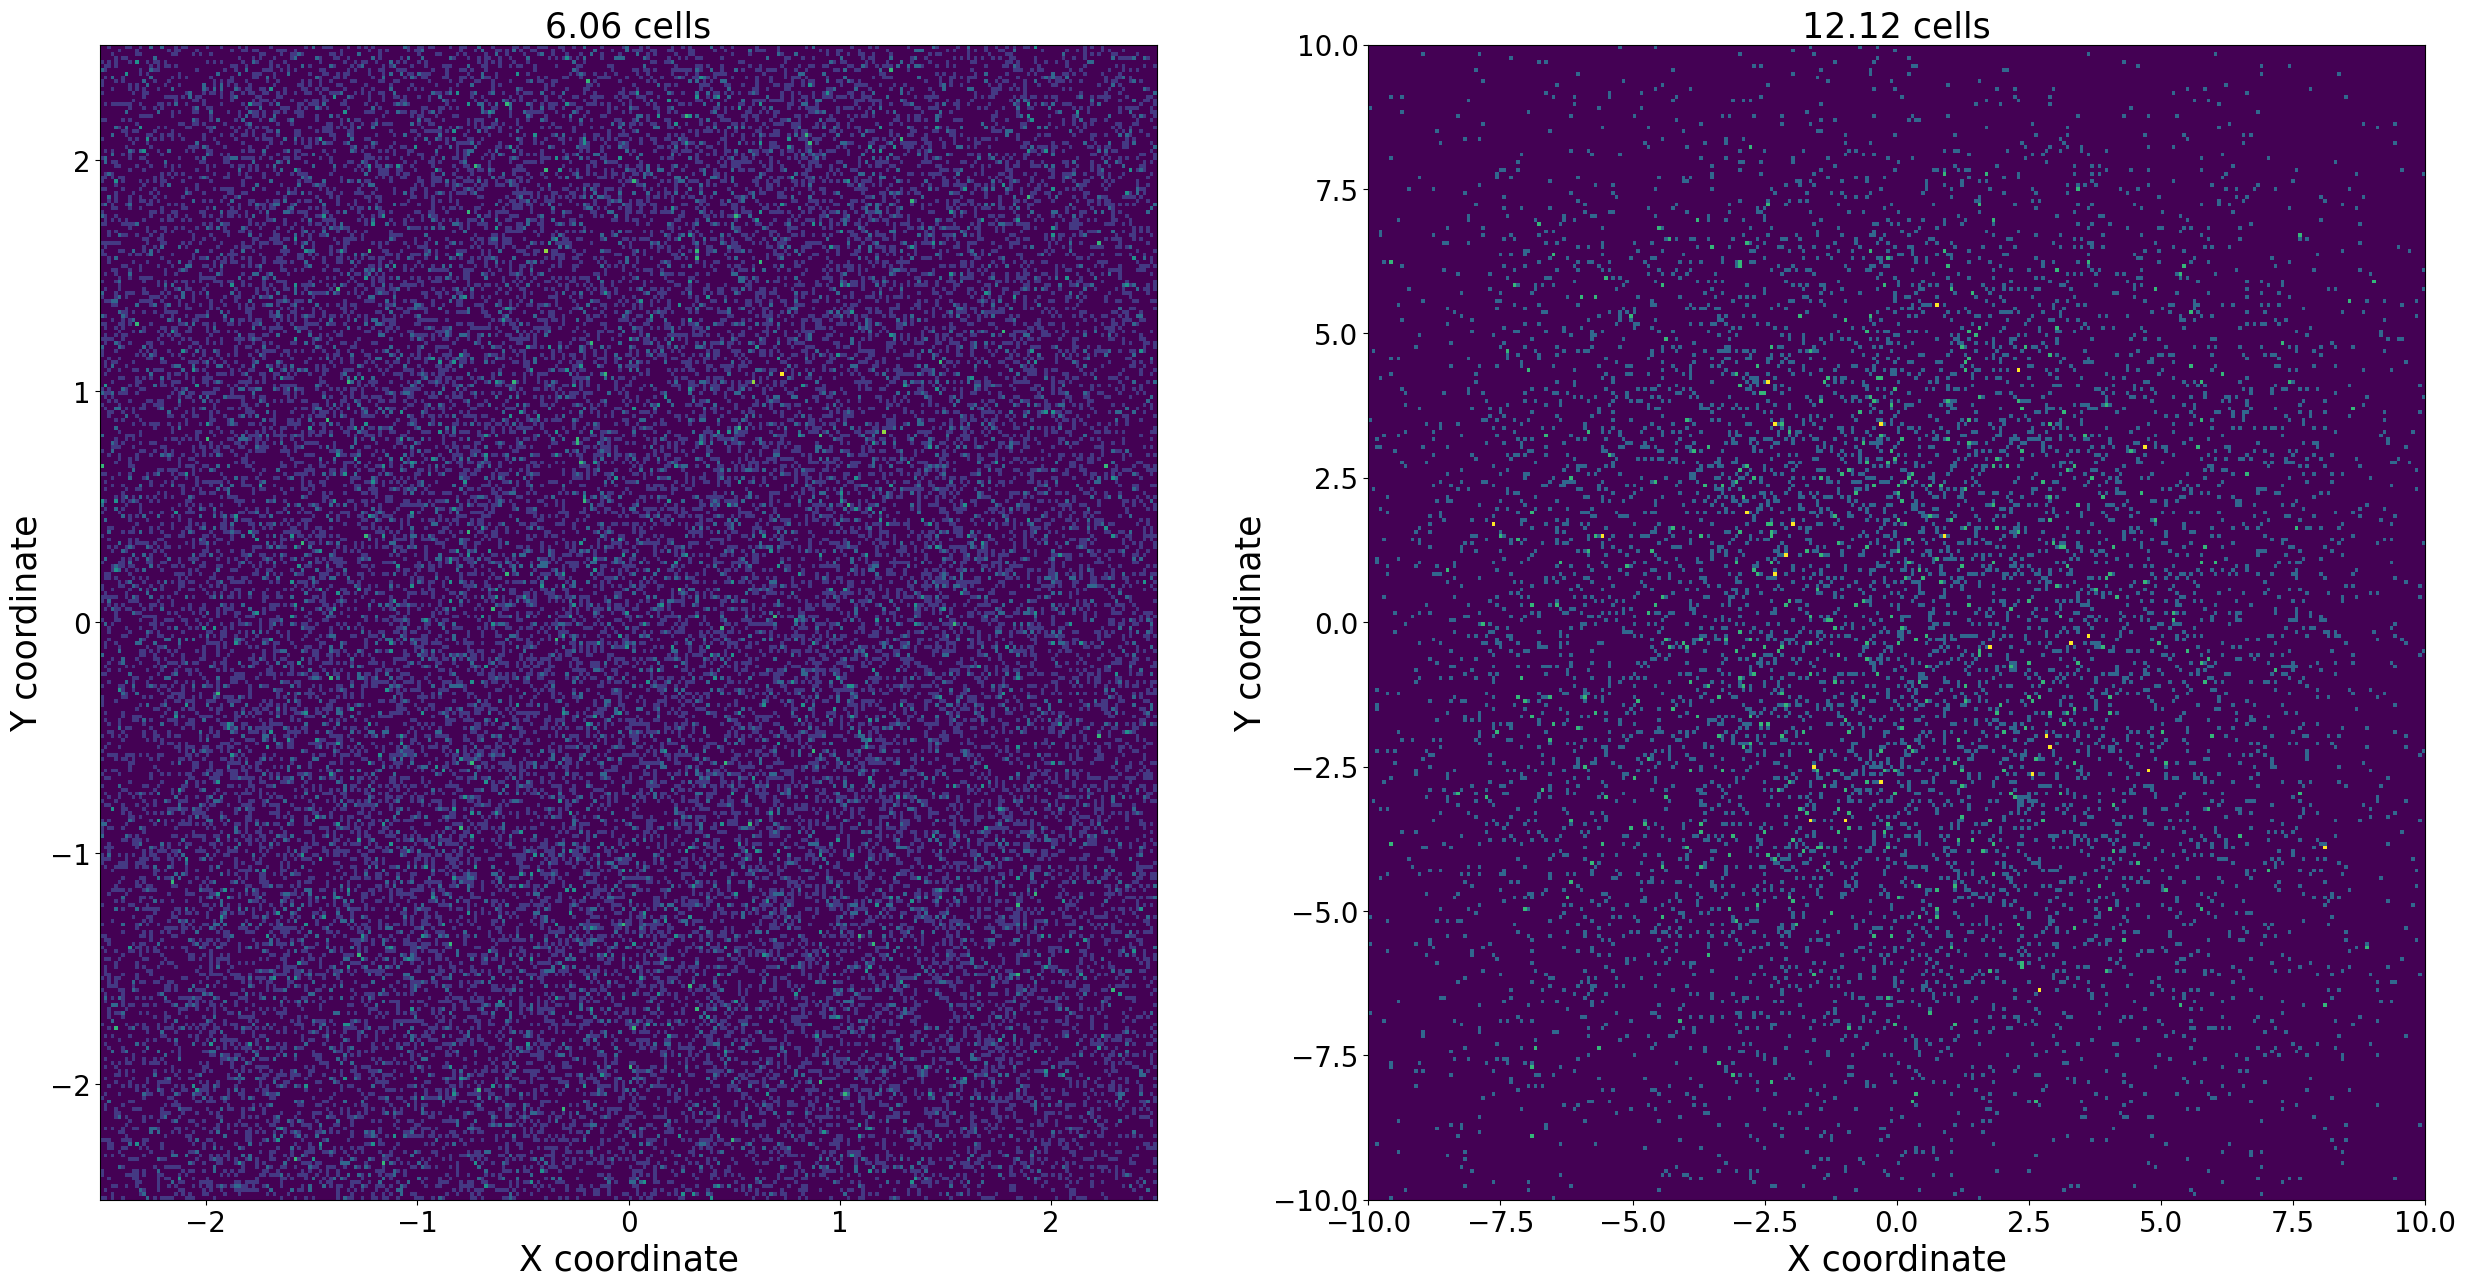

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].hist2d(data_train[data_train.cell_size == cell_sizes[3]].l0_yGen_loc, data_train[data_train.cell_size == cell_sizes[3]].l0_xGen_loc, bins=300, \
                 range = [[-2.5,2.5],[-2.5,2.5]])
axs[0].set_title(str(cell_sizes[3]) + ' cells', fontsize = font_size)
axs[1].hist2d(data_train[data_train.cell_size == cell_sizes[4]].l0_yGen_loc, data_train[data_train.cell_size == cell_sizes[4]].l0_xGen_loc, bins=300, \
                 range = [[-10,10],[-10,10]])
axs[1].set_title(str(cell_sizes[4]) + ' cells', fontsize = font_size)

for ax in axs.flat:
   ax.set_xlabel('X coordinate', fontsize=font_size)
   ax.set_ylabel('Y coordinate', fontsize=font_size)

#fig.delaxes(axs[1,2])
fig.set_figheight(15)
fig.set_figwidth(30)

In [13]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.X = torch.tensor(np.array(X[:,:25]).reshape(len(X),1,5,5),dtype=torch.float32)
    self.feat = torch.tensor(np.array(X[:,25:]),dtype=torch.float32)
    self.y = torch.tensor(np.array(y),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx],self.feat[idx], self.y[idx]

In [14]:
data_train

,runNumber,evtNumber,evtIndex,prod_vertex_x,prod_vertex_y,prod_vertex_z,entry_x,entry_y,entry_z,px,...,l0_x_bar_cal,l0_xRec_loc,l0_xGen_loc,l0_y_bar,entry_y_new,l0_y_bar_cal,l0_yRec_loc,l0_yGen_loc,t0_weighted_3x3,t0_weighted_5x5
0,666,6051,0,-830.238837,-43.902127,12039.559208,-898.586070,-27.695497,12620.0,-478.642784,...,-89.110626,0.274374,-1.651113,-0.106242,-24.903372,-1.621242,-0.106242,-0.975337,8.604970e+01,8.602384e+01
1,666,6051,0,-830.238804,-43.902134,12039.559397,-869.766946,-35.421831,12620.0,-322.870145,...,-89.110626,0.274374,1.727303,2.923758,-33.960819,-1.621242,-0.106242,-1.881082,8.604970e+01,8.602384e+01
2,666,6051,0,34.845277,31.003130,4631.168135,547.022763,-236.376609,12620.0,225.805553,...,55.981817,-0.073183,-0.711607,1.173273,-239.723529,-21.551727,1.173273,-1.247353,8.600710e+01,8.605714e+01
3,666,6051,0,-0.024234,-0.021201,-59.544035,-168.658536,-484.246651,12620.0,-41.986119,...,-13.828647,-0.193647,-3.363851,5.334230,-488.065601,-41.630770,-0.725770,-7.901560,8.590364e+01,8.584514e+01
4,666,6051,0,-0.024234,-0.021201,-59.544035,-1253.181624,729.837446,12620.0,-292.437384,...,-124.761414,-1.541414,-3.778323,-5.881285,739.622969,68.858715,-1.841285,3.262297,-1.788332e+36,-5.651775e+36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642553,666,7250,999,-236.261996,148.632678,12017.227336,-355.565642,112.409183,12620.0,-698.361085,...,-35.624419,-0.021919,-1.339538,-0.069530,108.202548,11.292970,-0.069530,-0.542245,8.594869e+01,8.595159e+01
642554,666,7250,999,0.024279,0.027073,7.349056,-174.369309,325.427129,12620.0,-29.465579,...,-16.862122,0.560378,-0.111219,-1.705312,327.233093,30.867188,-0.190312,1.665809,8.563599e+01,8.565155e+01
642555,666,7250,999,0.024279,0.027073,7.349056,1513.867338,-254.578276,12620.0,560.097329,...,151.370544,-0.129456,1.927172,-2.650468,-258.009982,-28.910468,1.389532,4.499002,-5.194555e+36,-1.651027e+37
642556,666,7250,999,-733.309265,-279.444304,12041.901158,-819.393502,-269.177856,12620.0,-417.707427,...,-82.048651,1.276349,-0.103442,-2.001970,-267.401958,-27.756970,1.028030,2.044804,8.616513e+01,8.626701e+01


In [15]:
train_features = []

for layer in layers:
        train_features += \
            ['l{}_{}'.format(layer, i) for i in range(25)] +\
            ['l{}_xRec_loc'.format(layer), 'l{}_yRec_loc'.format(layer)] +\
             ['l{}_sum_5x5_rec'.format(layer)] + \
             ['l{}_sum_3x3'.format(layer)] + \
             ['l{}_sum_5x5'.format(layer)] 

In [16]:
cell_size = cell_sizes_cm[0]

In [17]:
cell_size

1.515

In [18]:
data = data_train[data_train['cell_size'] == cell_size][train_features]
target_x = data_train[data_train['cell_size'] == cell_size]['l0_xGen_loc'].values
target_y = data_train[data_train['cell_size'] == cell_size]['l0_yGen_loc'].values


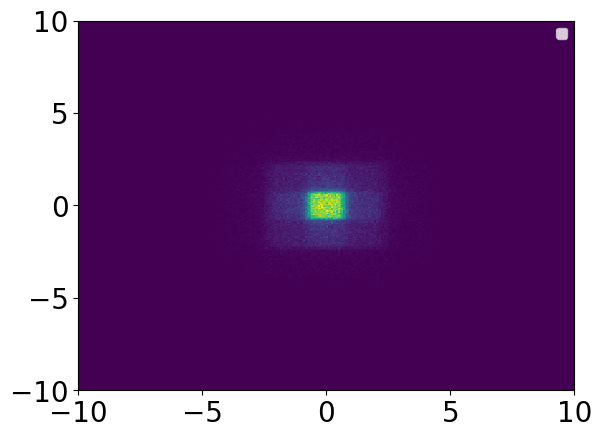

In [19]:
import seaborn as sns, matplotlib.pyplot as plt
image = plt.hist2d(target_x, target_y, bins= 300, density = True, range = [[-10,10],[-10,10]])
plt.legend()

## Modelling ##

In [20]:
import torch
import torch.nn as nn

def conv_block(input_size, output_size, kernel_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, kernel_size, bias= False), nn.LeakyReLU(0.15), nn.BatchNorm2d(output_size), nn.Dropout(0.2),
    )

    return block

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block1 = conv_block(1,128,(3,3))
        self.conv_block2 = conv_block(128,256,(3,3))
        self.conv_block3 = conv_block(256,256,(1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(261, 512)
        self.relu1 = nn.LeakyReLU(0.25)
        self.linear2 = nn.Linear(512, 64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(64)
        self.linear3 = nn.Linear(64, 1)
        self.drop = nn.Dropout(0.35)
        
    def forward(self, x, feat):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = torch.hstack((x,feat))
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        #x = self.drop(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop(x)
        x = self.linear3(x)
        return self.relu2(x)


def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

cnn = CNN()
cnn.apply(init_weights)


CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=261, out_features=512, bias=True)
  (relu1): LeakyReLU(negative_slope=0.25)
  (linear2): Linea

In [21]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.linear1 = nn.Linear(25,16)
        self.linear2 = nn.Linear(21,8)
        self.linear3 = nn.Linear(8,1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        self.flatten = nn.Flatten()

        
    def forward(self, x, feat):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = torch.hstack((x,feat))
        x = self.linear2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.linear3(x)
        return x

## Reconstructing one coordinate ##

In [22]:
data['target'] = target_x
#data['target'] = target_y

In [23]:
X_train,X_val,y_train,y_val = train_test_split(data.drop('target',axis=1), data.target, random_state=42, shuffle=True)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler_data = StandardScaler()
scaler_target = StandardScaler()

X_train = scaler_data.fit_transform(X_train)
#y_train = scaler_target.fit_transform(y_train.values.reshape(-1,1))

X_val = scaler_data.transform(X_val)

mu_y = y_train.mean()
std_y = y_train.std()
y_train -= mu_y
y_train /= std_y

In [25]:
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error

# hist, bin_edges = np.histogram(y_train, bins = 20)
# classes = pd.DataFrame(y_train).apply(lambda x: pd.cut(x, bin_edges, labels = False, 
#                                                    include_lowest = True)).values
# classes_val = pd.DataFrame(y_val).apply(lambda x: pd.cut(x, bin_edges, labels = False, 
#                                                    include_lowest = True)).values

# sample_weights = compute_sample_weight('balanced', classes)
# classes_val_weights = compute_sample_weight('balanced', classes_val)
# t_c = X_train.columns
#X_train_resampled, classes_resam = rus.fit_resample(X_train, classes)
#X_train_resampled = pd.DataFrame(X_train_resampled, columns=t_c)

(array([1.000e+00, 0.000e+00, 4.000e+00, 1.200e+01, 2.600e+01, 1.010e+02,
        1.570e+02, 2.260e+02, 4.850e+02, 1.435e+03, 2.323e+03, 2.809e+03,
        3.631e+03, 8.120e+03, 9.682e+03, 9.373e+03, 6.583e+03, 3.038e+03,
        2.596e+03, 2.144e+03, 1.069e+03, 3.850e+02, 1.790e+02, 1.450e+02,
        6.600e+01, 1.600e+01, 7.000e+00, 5.000e+00, 0.000e+00, 3.000e+00]),
 array([-6.36373893, -5.93537164, -5.50700436, -5.07863707, -4.65026978,
        -4.22190249, -3.7935352 , -3.36516791, -2.93680062, -2.50843333,
        -2.08006604, -1.65169876, -1.22333147, -0.79496418, -0.36659689,
         0.0617704 ,  0.49013769,  0.91850498,  1.34687227,  1.77523955,
         2.20360684,  2.63197413,  3.06034142,  3.48870871,  3.917076  ,
         4.34544329,  4.77381058,  5.20217787,  5.63054515,  6.05891244,
         6.48727973]),
 <BarContainer object of 30 artists>)

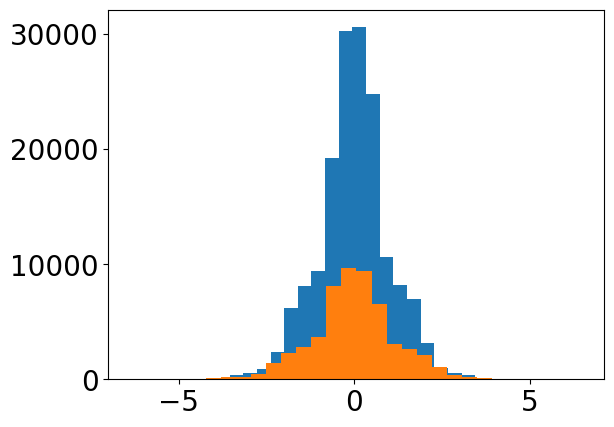

In [26]:
import matplotlib.pyplot as plt

plt.hist(y_train,bins=30)
plt.hist(y_val,bins=30)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 5.000e+00,
        1.200e+01, 1.600e+01, 3.100e+01, 7.500e+01, 8.600e+01, 1.180e+02,
        1.450e+02, 1.790e+02, 3.400e+02, 7.310e+02, 1.137e+03, 1.404e+03,
        1.582e+03, 1.713e+03, 1.849e+03, 3.046e+03, 5.036e+03, 5.706e+03,
        5.796e+03, 5.655e+03, 5.471e+03, 3.947e+03, 2.213e+03, 1.708e+03,
        1.568e+03, 1.510e+03, 1.309e+03, 9.220e+02, 5.000e+02, 2.670e+02,
        1.520e+02, 1.100e+02, 9.700e+01, 8.300e+01, 4.700e+01, 2.400e+01,
        9.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([-6.36373893, -6.10671856, -5.84969819, -5.59267781, -5.33565744,
        -5.07863707, -4.82161669, -4.56459632, -4.30757595, -4.05055557,
        -3.7935352 , -3.53651483, -3.27949445, -3.02247408, -2.76545371,
        -2.50843333, -2.25141296, -1.99439259, -1.73737221, -1.48035184,
        -1.22333147, -0.96631109, -0.70929072, -0.45227035, -0.19524997,
         0.

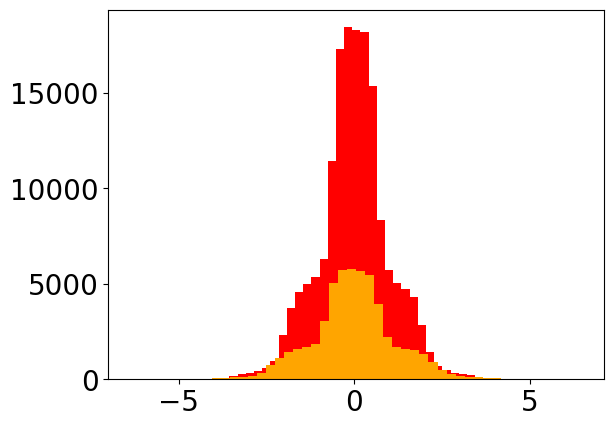

In [27]:
import matplotlib.pyplot as plt
plt.hist(y_train, color = 'red',bins=50)
#plt.hist(y_train_resampled, color = 'blue', bins=50)
plt.hist(y_val, color = 'orange',bins=50)

In [28]:
train_set = MyDataset(X_train, y_train)
val_set = MyDataset(X_val, y_val)

training_loader = DataLoader(train_set, batch_size = 1024,)# sampler = wrs)
validation_loader = DataLoader(val_set, batch_size = 1024,)# sampler = wrs_v)

In [29]:
def early_stopping(val_loss, patiance = 5):
  counter = 0.
  for v in range(patiance):
    if val_loss[-v] > val_loss[-v-1]:
      counter += 1.
    else:
      False

  if patiance == counter:
    return True

In [30]:
train_losses = []
val_losses = [] 

def train_regression_model(model, criterion,  val_crit, optimizer, train_loader, val_loader, num_epochs, patiance = 5):
    # set up the device to use for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = 0.
    best_validation = float('inf')

    # train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, feats, labels = data

            # move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            feats = feats.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs,feats).squeeze()
            loss = criterion(outputs*std_y + mu_y, labels.squeeze()*std_y + mu_y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            running_loss += loss.item()
            #running_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 

       
        epoch_loss = np.sqrt(running_loss / len(train_loader))  # calculate the average epoch loss
        running_loss = 0
        train_losses.append(epoch_loss)
        print(f"Average training loss for epoch {epoch+1}: {epoch_loss:.5f}")

        running_val_loss = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, feats, labels = data

                # move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)
                feats = feats.to(device)

                # forward pass
                outputs = model(inputs,feats).squeeze()
                loss = val_crit(outputs*std_y + mu_y, labels.squeeze())

                # accumulate validation loss
                #running_val_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), 
                #                              sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 
                running_val_loss += loss.item()
        val_loss = np.sqrt(running_val_loss / len(val_loader))
        if val_loss < best_validation:
          best_model = model
          best_validation = val_loss

        val_losses.append(val_loss)
        print(f"Average validation loss for epoch {epoch+1}: {val_loss:.5f}")
       
        if epoch > patiance:
          if early_stopping(val_losses,patiance):
            print('Early stopping')
            break
      
    torch.save(model.state_dict(), '/content/attempt1/epoch'+str(epoch))
    return best_model
    print('Finished Training')


(array([1.000e+00, 0.000e+00, 4.000e+00, 1.200e+01, 2.600e+01, 1.010e+02,
        1.570e+02, 2.260e+02, 4.850e+02, 1.435e+03, 2.323e+03, 2.809e+03,
        3.631e+03, 8.120e+03, 9.682e+03, 9.373e+03, 6.583e+03, 3.038e+03,
        2.596e+03, 2.144e+03, 1.069e+03, 3.850e+02, 1.790e+02, 1.450e+02,
        6.600e+01, 1.600e+01, 7.000e+00, 5.000e+00, 0.000e+00, 3.000e+00]),
 array([-6.36373893, -5.93537164, -5.50700436, -5.07863707, -4.65026978,
        -4.22190249, -3.7935352 , -3.36516791, -2.93680062, -2.50843333,
        -2.08006604, -1.65169876, -1.22333147, -0.79496418, -0.36659689,
         0.0617704 ,  0.49013769,  0.91850498,  1.34687227,  1.77523955,
         2.20360684,  2.63197413,  3.06034142,  3.48870871,  3.917076  ,
         4.34544329,  4.77381058,  5.20217787,  5.63054515,  6.05891244,
         6.48727973]),
 <BarContainer object of 30 artists>)

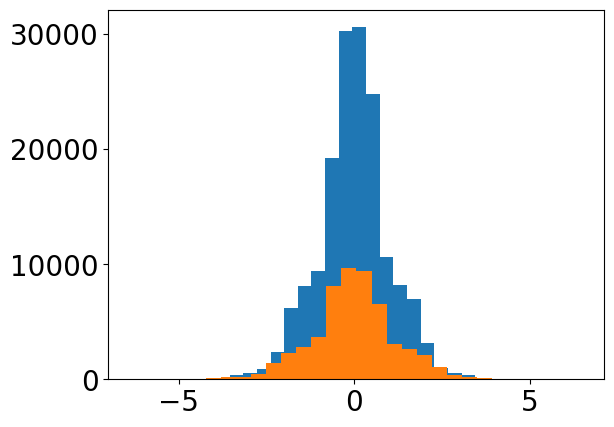

In [31]:
plt.hist(y_train, bins=30)
plt.hist(y_val, bins=30)

In [32]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 7), torch.log(actual + 7)))

In [33]:
%%capture
!pip install torchinfo
from torchinfo import summary

In [34]:
summary(cnn)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,152
│    └─LeakyReLU: 2-2                    --
│    └─BatchNorm2d: 2-3                  256
│    └─Dropout: 2-4                      --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       294,912
│    └─LeakyReLU: 2-6                    --
│    └─BatchNorm2d: 2-7                  512
│    └─Dropout: 2-8                      --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-9                       65,536
│    └─LeakyReLU: 2-10                   --
│    └─BatchNorm2d: 2-11                 512
│    └─Dropout: 2-12                     --
├─Flatten: 1-4                           --
├─Linear: 1-5                            134,144
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            32,832
├─LeakyReLU: 1-8                         --
├─B

In [35]:
#loss_fn = RMSLELoss()
#loss_fn = my_loss
val_loss = torch.nn.MSELoss()
loss_fn = torch.nn.MSELoss()
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.1)#weight_decay = 0.000001)
cnn.apply(init_weights)
train_losses = []
val_losses = [] 


In [37]:
best_model = train_regression_model(cnn, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=250, patiance = 80)

Average training loss for epoch 1: 0.81846
Average validation loss for epoch 1: 0.83758


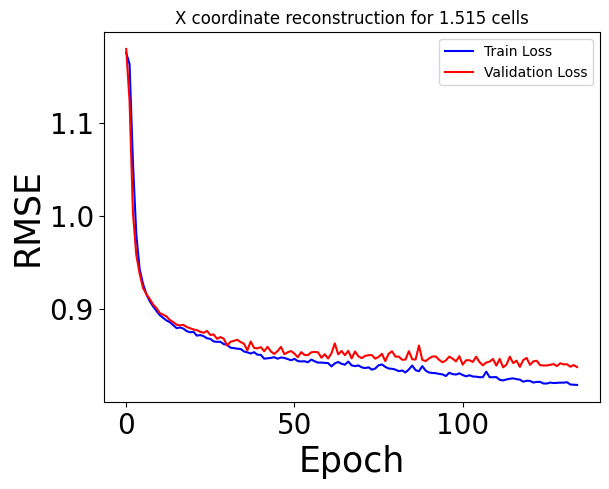

In [38]:
plt.plot(train_losses[1:],color = 'blue', label = 'Train Loss')
plt.plot(val_losses[1:], color = 'red', label = 'Validation Loss')
plt.title("X coordinate reconstruction for {} cells".format(cell_size))
plt.ylabel("RMSE", fontsize = 25)
plt.xlabel("Epoch", fontsize = 25)
plt.legend()

In [39]:
from sklearn.model_selection import KFold

def experiment(architecture, n_splits = 5):

    kf = KFold(n_splits=n_splits, random_state=22, shuffle=True)
    kf.get_n_splits(data)

    metrics = []

    for train_index, val_index in kf.split(data):

        if architecture == 'cnn':
          model = CNN()
          model.apply(init_weights)
        elif architecture == 'dnn':
          model = DNN()
          model.apply(init_weights)

        test_index = val_index[len(val_index)//2:]
        val_index = val_index[:len(val_index)//2]
        

        X_train = data.iloc[train_index].drop('target',axis=1)
        X_val = data.iloc[val_index].drop('target',axis=1)
        X_test = data.iloc[test_index].drop('target',axis=1)

        y_train = data.iloc[train_index]['target']
        y_val = data.iloc[val_index]['target']
        y_test = data.iloc[test_index]['target']


        scaler_data = StandardScaler()
        scaler_target = StandardScaler()

        X_train = scaler_data.fit_transform(X_train)

        X_val = scaler_data.transform(X_val)
        X_test = scaler_data.transform(X_test)

        mu_y = y_train.mean()
        std_y = y_train.std()
        y_train -= mu_y
        y_train /= std_y


        train_set = MyDataset(X_train,y_train)
        val_set = MyDataset(X_val,y_val)
        test_set = MyDataset(X_test,y_test)

        training_loader = DataLoader(train_set,batch_size = 512)
        validation_loader = DataLoader(val_set,batch_size = 512)
        testing_loader = DataLoader(test_set,batch_size = 512)
        


        val_loss = torch.nn.MSELoss()
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)#,weight_decay = 0.000001)


        train_losses = []
        val_losses = [] 
        best_model = train_regression_model(model, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=60, patiance = 15)


        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        preds = []
        for X, feat, y in testing_loader:
          predictions = best_model(X.to(device), feat.to(device))
          predictions = predictions*std_y + mu_y
          for pred in predictions:
            preds.append(pred.item())

        metrics.append(mean_squared_error(preds, y_test, squared = False))
      
    return metrics
        

In [40]:
metrics = experiment('cnn')

Average training loss for epoch 1: 1.72068
Average validation loss for epoch 1: 1.06225
Average training loss for epoch 2: 1.00071
Average validation loss for epoch 2: 0.95867
Average training loss for epoch 3: 0.93750
Average validation loss for epoch 3: 0.92767
Average training loss for epoch 4: 0.91652
Average validation loss for epoch 4: 0.91456
Average training loss for epoch 5: 0.90527
Average validation loss for epoch 5: 0.90710
Average training loss for epoch 6: 0.89571
Average validation loss for epoch 6: 0.89917
Average training loss for epoch 7: 0.88897
Average validation loss for epoch 7: 0.89361
Average training loss for epoch 8: 0.88488
Average validation loss for epoch 8: 0.88746
Average training loss for epoch 9: 0.88067
Average validation loss for epoch 9: 0.88296
Average training loss for epoch 10: 0.87668
Average validation loss for epoch 10: 0.88197
Average training loss for epoch 11: 0.87292
Average validation loss for epoch 11: 0.87903
Average training loss for ep

In [41]:
print("MEAN RMSE FOR X", np.array(metrics).mean())
print("STD OF RMSE FOR X", np.array(metrics).std(ddof = 1))

MEAN RMSE FOR X 0.842849945544511
STD OF RMSE FOR X 0.00600841889901715


In [43]:
import xgboost as xgb
from sklearn.model_selection import KFold

def get_xgb_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    kf.get_n_splits(X)

    predict_train = np.zeros(len(X))

    for train_index, val_index in kf.split(X):

        model = xgb.XGBRegressor(
                                 n_estimators=250,
                                 random_state=42,
                                 verbosity = 0)

        model.fit(X[train_index], y[train_index])

        predict_train[val_index] = model.predict(X[val_index])

    return predict_train

In [45]:
preds_xgb = get_xgb_model(data.drop('target',axis=1).values, target_x)

In [47]:
print("MEAN RMSE FOR X: {} \nSTD OF RMSE FOR X: {}".format(*get_rmse_metric(preds_xgb,data['target'].values)))

MEAN RMSE FOR X: 0.8492676030815046 
STD OF RMSE FOR X: 0.002538566105703726


##2 output model##

In [59]:

import torch
import torch.nn as nn

def conv_block(input_size, output_size, kernel_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, kernel_size, bias= False), nn.LeakyReLU(0.15), nn.BatchNorm2d(output_size), nn.Dropout(0.2),
    )

    return block

class CNN_XY(nn.Module):
    def __init__(self):
        super(CNN_XY, self).__init__()
        self.conv_block1 = conv_block(1,128,(3,3))
        self.conv_block2 = conv_block(128,256,(3,3))
        self.conv_block3 = conv_block(256,256,(1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(261, 512)
        self.relu1 = nn.LeakyReLU(0.25)
        self.linear2 = nn.Linear(512, 64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(64)
        self.linear3 = nn.Linear(64, 2)
        self.drop = nn.Dropout(0.35)
        
    def forward(self, x, feat):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = torch.cat((x,feat),dim=1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        #x = self.drop(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop(x)
        x = self.linear3(x)
        return self.relu2(x)

class DNN_XY(nn.Module):
    def __init__(self):
        super(DNN_XY, self).__init__()
        
        self.linear1 = nn.Linear(25,16)
        self.linear2 = nn.Linear(21,8)
        self.linear3 = nn.Linear(8,2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        self.flatten = nn.Flatten()

        
    def forward(self, x, feat):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = torch.hstack((x,feat))
        x = self.linear2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.linear3(x)
        return x


def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

cnn_xy = CNN_XY()
cnn_xy.apply(init_weights)

CNN_XY(
  (conv_block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.15)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=261, out_features=512, bias=True)
  (relu1): LeakyReLU(negative_slope=0.25)
  (linear2): Li

In [60]:
class DatasetXY(Dataset):
 
  def __init__(self,X,y):
    self.data = torch.tensor(np.array(X[:,:25]).reshape(len(X),1,5,5),dtype=torch.float32)
    self.feat = torch.tensor(np.array(X[:,25:]),dtype=torch.float32)
    self.x = torch.tensor(np.array(y.iloc[:,0]),dtype=torch.float32)
    self.y = torch.tensor(np.array(y.iloc[:,1]),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.data[idx],self.feat[idx], self.x[idx],self.y[idx]

In [61]:
cell_size = cell_sizes_cm[3]

In [62]:
data = data_train[data_train['cell_size'] == cell_size][train_features]
target_x = data_train[data_train['cell_size'] == cell_size]['l0_xGen_loc'].values
target_y = data_train[data_train['cell_size'] == cell_size]['l0_yGen_loc'].values


data['target_x'] = target_x
data['target_y'] = target_y



train_d,val_d,train_tar,val_tar = train_test_split(data.drop(['target_x', 'target_y'],axis=1), data[['target_x','target_y']], random_state=42, shuffle=True)


train_set = DatasetXY(train_d.values, train_tar)
val_set = DatasetXY(val_d.values, val_tar)

training_loader = DataLoader(train_set, batch_size = 1024)
validation_loader = DataLoader(val_set, batch_size = 1024)

In [64]:
train_losses_x = []
val_losses_x = [] 

train_losses_y = []
val_losses_y = [] 

val_loss = []

def train_regression_model_XY(model, criterion,  val_crit, optimizer, train_loader, val_loader, num_epochs, patiance = 5):
    # set up the device to use for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = 0.
    best_validation = float('inf')

    # train the model
    for epoch in range(num_epochs):
        running_loss_x = 0.0
        running_loss_y = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs,feat, x, y = data

            # move the inputs and labels to the device
            inputs = inputs.to(device)
            feat = feat.to(device)
            x = x.to(device)
            y = y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs, feat).squeeze()
            loss_x = criterion(outputs[:,0], x)
            loss_y = criterion(outputs[:,1], y)
            loss = loss_x + loss_y
            loss.backward()
            optimizer.step()

            running_loss_x += loss_x.item()
            running_loss_y += loss_y.item()
            #running_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 

       
        epoch_loss_x = np.sqrt(running_loss_x / len(train_loader))  # calculate the average epoch loss
        epoch_loss_y = np.sqrt(running_loss_y / len(train_loader))
        running_loss = 0
        train_losses_x.append(epoch_loss_x)
        train_losses_y.append(epoch_loss_y)
        print(f"Average training loss for epoch {epoch+1}: {epoch_loss_x:.5f}")
        print(f"Average training loss for epoch {epoch+1}: {epoch_loss_y:.5f}")
        val_loss = 0.
        running_val_loss_x = 0.0
        running_val_loss_y = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs,feat, x, y = data

                # move the inputs and labels to the device
                inputs = inputs.to(device)
                feat = feat.to(device)
                x = x.to(device)
                y = y.to(device)


                # forward pass
                outputs = model(inputs, feat).squeeze()
                loss_x = criterion(outputs[:,0], x)
                loss_y = criterion(outputs[:,1], y)
                loss = loss_x + loss_y

                running_val_loss_x += loss_x.item()
                running_val_loss_y += loss_y.item()

                # accumulate validation loss
                #running_val_loss += mean_squared_error(sctarg.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), 
                #                              sctarg.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 
                #running_val_loss += loss.item()
                val_loss = running_val_loss_x + running_val_loss_y

        val_loss_x = np.sqrt(running_val_loss_x / len(val_loader))
        val_loss_y = np.sqrt(running_val_loss_y / len(val_loader))
        
        val_loss = np.sqrt(val_loss / len(val_loader))
        val_losses.append(val_loss)
        
        if val_loss < best_validation:
          best_model = model
          best_validation = val_loss
  

        val_losses_x.append(val_loss_x)
        val_losses_y.append(val_loss_y)
        print(f"Average validation loss of x for epoch {epoch+1}: {val_loss_x:.5f}")
        print(f"Average validation loss of y for epoch {epoch+1}: {val_loss_y:.5f}")
        if epoch > patiance:
          if early_stopping(val_losses,patiance):
            print('Early stopping')
            break
      
    torch.save(model.state_dict(), '/content/attempt1/epoch'+str(epoch))
    return best_model
    print('Finished Training')


In [70]:
optimizer = torch.optim.Adam(cnn_xy.parameters(), lr=0.01)#,weight_decay = 0.000001)
cnn_xy.apply(init_weights)

train_losses = []
val_losses = [] 

train_losses_x = []
val_losses_x = [] 

train_losses_y = []
val_losses_y = [] 

best_model = train_regression_model_XY(cnn_xy, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=100, patiance = 10)

Average training loss for epoch 1: 3.51310
Average training loss for epoch 1: 3.24335
Average validation loss of x for epoch 1: 3.35588
Average validation loss of y for epoch 1: 2.92466
Average training loss for epoch 2: 3.28205
Average training loss for epoch 2: 2.78038
Average validation loss of x for epoch 2: 3.04879
Average validation loss of y for epoch 2: 2.73691
Average training loss for epoch 3: 2.97460
Average training loss for epoch 3: 2.67628
Average validation loss of x for epoch 3: 2.83691
Average validation loss of y for epoch 3: 2.63080
Average training loss for epoch 4: 2.84283
Average training loss for epoch 4: 2.60621
Average validation loss of x for epoch 4: 2.80696
Average validation loss of y for epoch 4: 2.57415
Average training loss for epoch 5: 2.80026
Average training loss for epoch 5: 2.53775
Average validation loss of x for epoch 5: 2.71552
Average validation loss of y for epoch 5: 2.52832
Average training loss for epoch 6: 2.73654
Average training loss for e

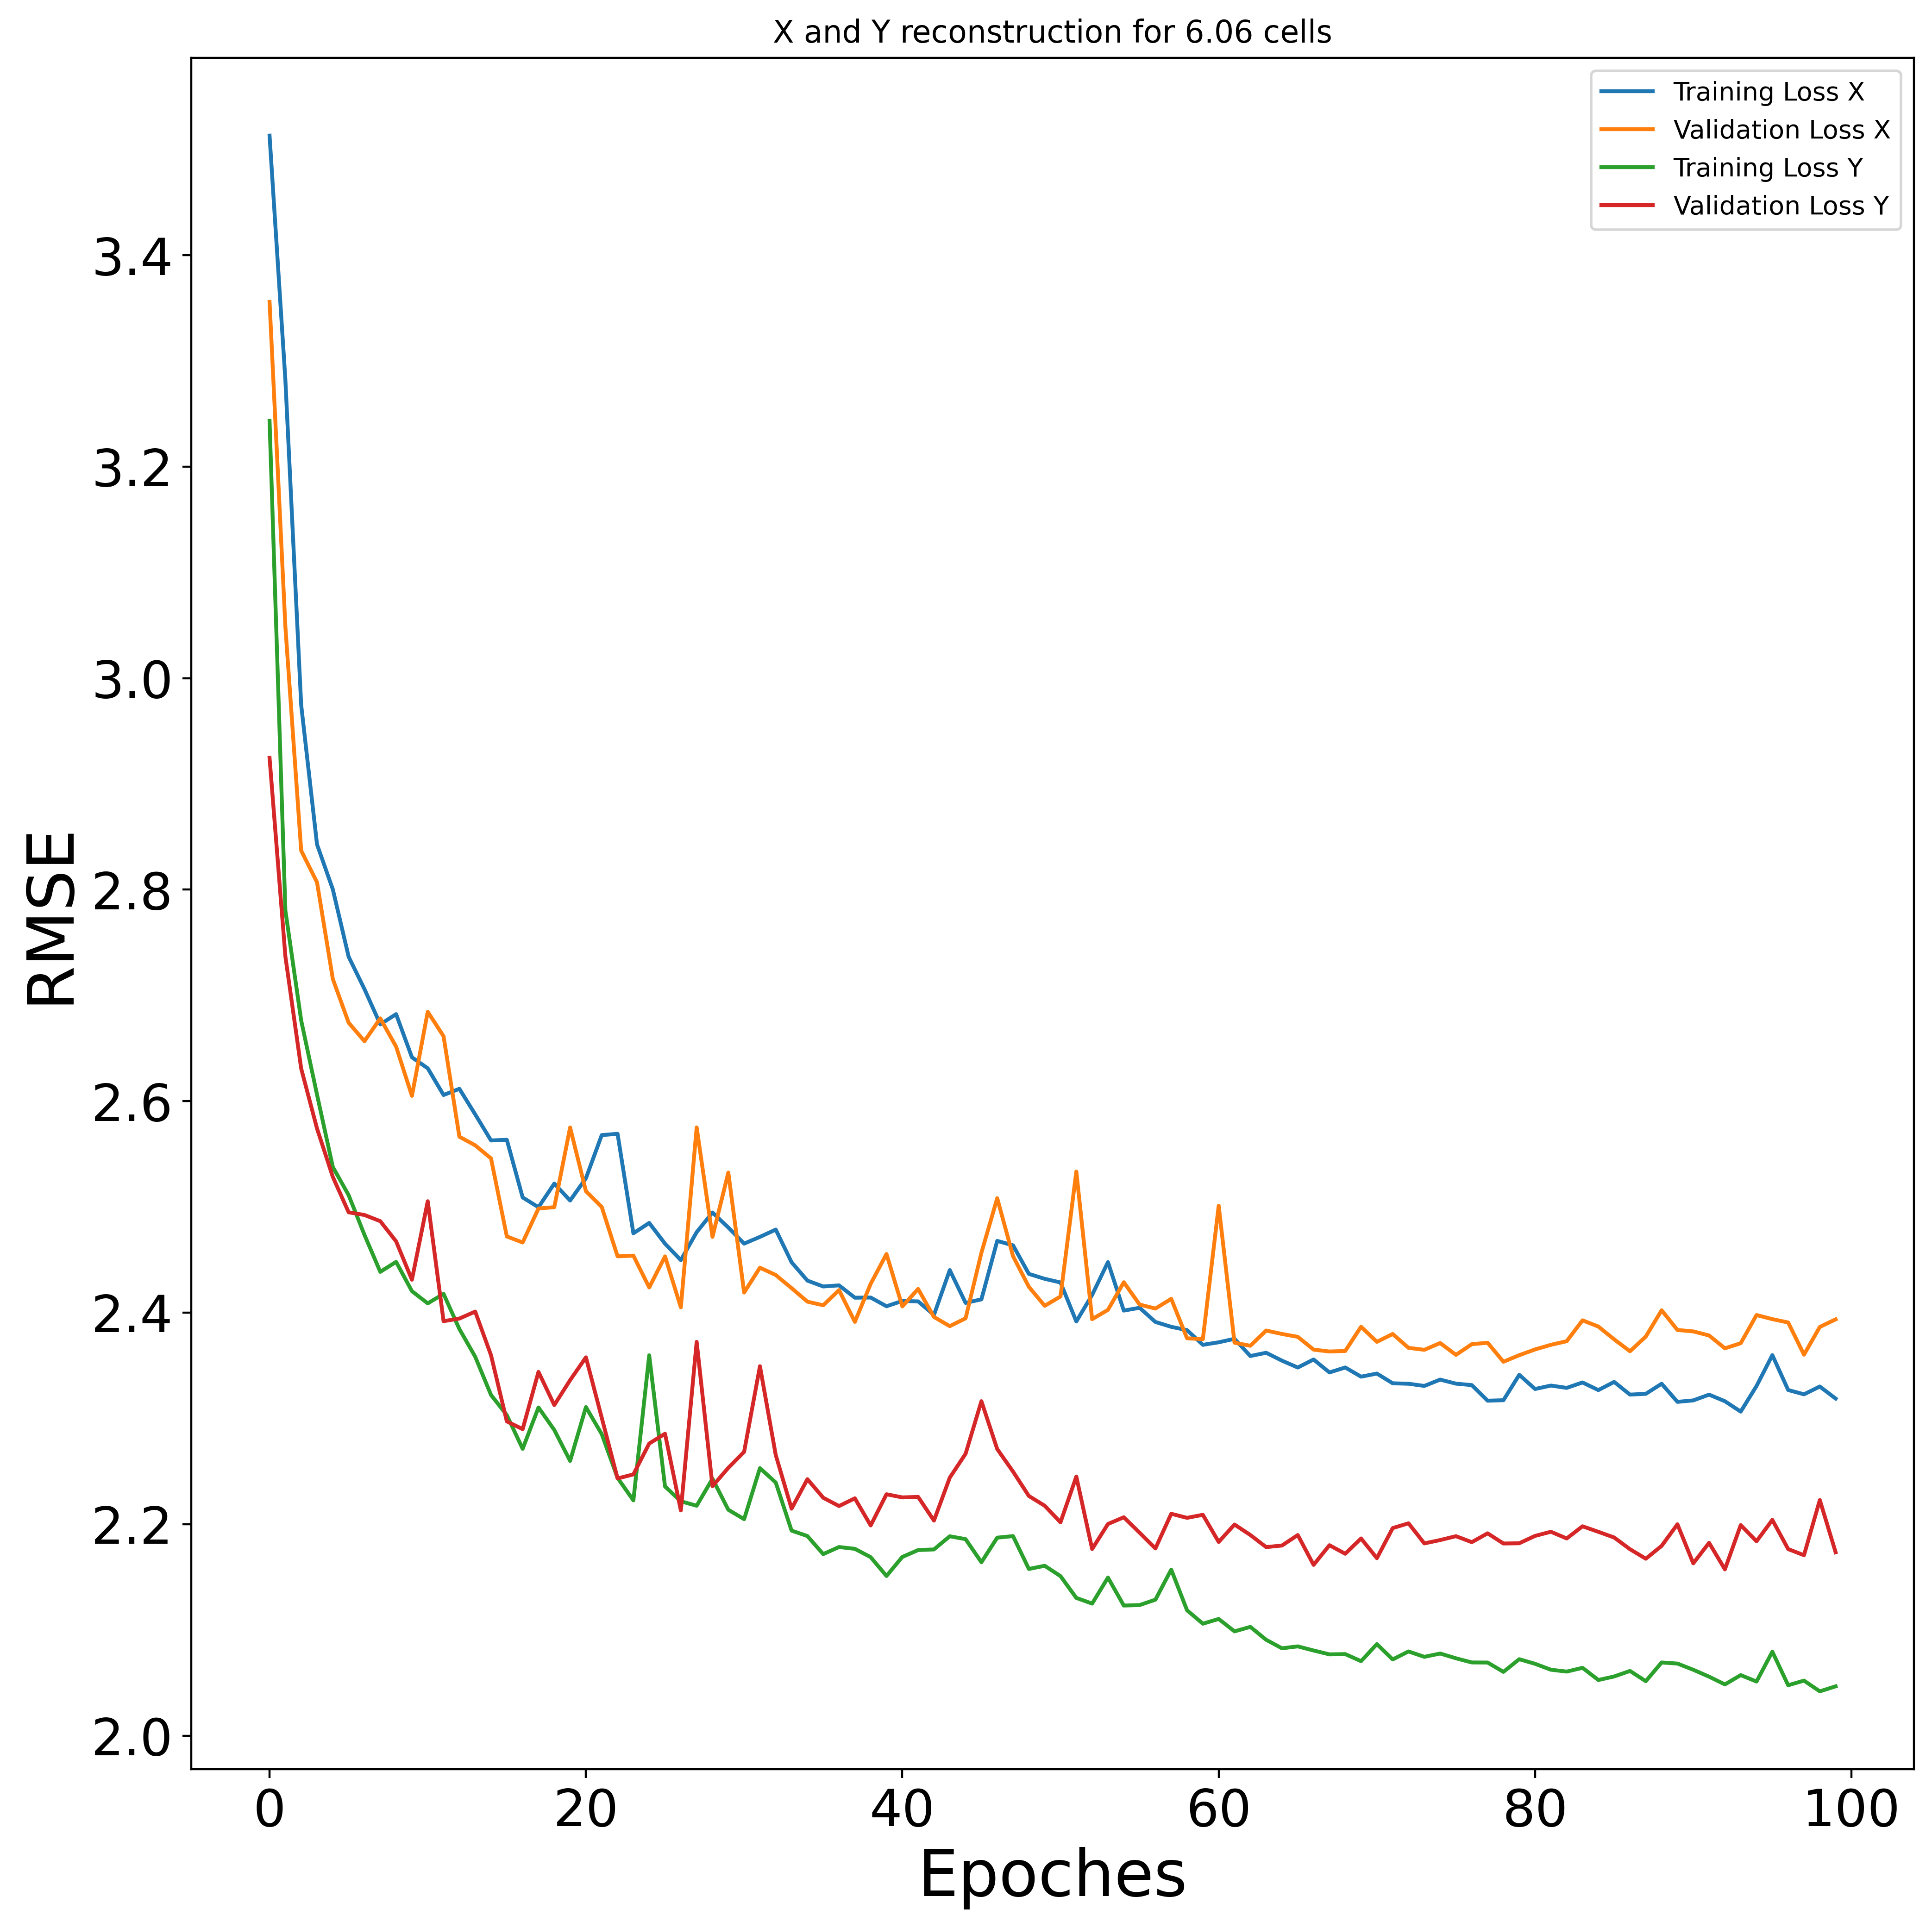

In [71]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=400)

plt.title('X and Y reconstruction for {} cells'.format(cell_size))
plt.plot(train_losses_x, label = 'Training Loss X')
plt.plot(val_losses_x, label = 'Validation Loss X')
plt.ylabel("RMSE", fontsize = 25)
plt.xlabel("Epoches", fontsize = 25)
plt.plot(train_losses_y,  label = 'Training Loss Y')
plt.plot(val_losses_y, label = 'Validation Loss Y')
#plt.yscale('log', base=2)
plt.legend()

In [72]:
from sklearn.model_selection import KFold

def experiment_xy(architecture, n_splits = 5):

    kf = KFold(n_splits=n_splits, random_state=22, shuffle=True)
    kf.get_n_splits(data)
    criterion = torch.torch.nn.MSELoss(reduction = 'sum')
    metrics = []

    for train_index, val_index in kf.split(data):

        if architecture == 'cnn':
          model = CNN_XY()
          model.apply(init_weights)
        elif architecture == 'dnn':
          model = DNN_XY()
          model.apply(init_weights)

        test_index = val_index[len(val_index)//2:]
        val_index = val_index[:len(val_index)//2]
        

        X_train = data.iloc[train_index].drop(['target_x','target_y'],axis=1)
        X_val = data.iloc[val_index].drop(['target_x','target_y'],axis=1)
        X_test = data.iloc[test_index].drop(['target_x','target_y'],axis=1)

        y_train = data.iloc[train_index][['target_x','target_y']]
        y_val = data.iloc[val_index][['target_x','target_y']]
        y_test = data.iloc[test_index][['target_x','target_y']]



        train_set = DatasetXY(X_train.values,y_train)
        val_set = DatasetXY(X_val.values,y_val)
        test_set = DatasetXY(X_test.values,y_test)

        training_loader = DataLoader(train_set,batch_size = 512)
        validation_loader = DataLoader(val_set,batch_size = 512)
        testing_loader = DataLoader(test_set,batch_size = 512)
        


        val_loss = torch.nn.MSELoss()
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)#,weight_decay = 0.000001)


        train_losses = []
        val_losses = [] 
        best_model = train_regression_model_XY(model, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=60, patiance = 15)


        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        preds = []
        loss_x = 0.
        loss_y = 0.
        for X, feat, x, y in testing_loader:
          predictions = best_model(X.to(device), feat.to(device))
          loss_x += criterion(predictions[:,0], x.to(device)).item()
          loss_y += criterion(predictions[:,1], y.to(device)).item()

        loss_x = np.sqrt(loss_x/len(testing_loader.dataset))
        loss_y = np.sqrt(loss_y/len(testing_loader.dataset))
        
        metrics.append([loss_x, loss_y])
        
      
    return np.array(metrics)
        

In [73]:
metrics = experiment_xy('cnn')

Average training loss for epoch 1: 3.79913
Average training loss for epoch 1: 3.38840
Average validation loss of x for epoch 1: 3.39252
Average validation loss of y for epoch 1: 3.26516
Average training loss for epoch 2: 3.36161
Average training loss for epoch 2: 3.23749
Average validation loss of x for epoch 2: 3.37655
Average validation loss of y for epoch 2: 3.26273
Average training loss for epoch 3: 3.12511
Average training loss for epoch 3: 3.23259
Average validation loss of x for epoch 3: 2.86538
Average validation loss of y for epoch 3: 3.25399
Average training loss for epoch 4: 2.80816
Average training loss for epoch 4: 3.22822
Average validation loss of x for epoch 4: 2.78817
Average validation loss of y for epoch 4: 3.24946
Average training loss for epoch 5: 2.74046
Average training loss for epoch 5: 3.22911
Average validation loss of x for epoch 5: 2.74111
Average validation loss of y for epoch 5: 3.25571
Average training loss for epoch 6: 2.70602
Average training loss for e

In [74]:
print("MEAN RMSE FOR X", metrics[:,0].mean())
print("STD OF RMSE FOR X", metrics[:,0].std(ddof = 1))

print("MEAN RMSE FOR Y", metrics[:,1].mean())
print("STD OF RMSE FOR Y", metrics[:,1].std(ddof = 1))

MEAN RMSE FOR X 2.4140046660829193
STD OF RMSE FOR X 0.03832915300793322
MEAN RMSE FOR Y 2.1675794403809054
STD OF RMSE FOR Y 0.029071739794552943
